# USING DEMOGRAPHICS AND VENUES DATA TO IDENTIFY NEIGHBOURHOODS TO OPEN A CAFE IN GREATER HOBART

## Applied Data Science Capstone by IBM/Coursera

## Table of contents
1 [Introduction](#introduction)  
2 [Data](#data)  
3 [Methodology](#methodology)  
4 [Analysis](#analysis)  
5 [Results](#results)  
6 [Discussion and Conclusion](#discussion)   
7 [References](#references)  

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


--------------------------------------------------------------------------------------------------------------------------

## 1. Introduction <a name="introduction"></a>

### 1.1.	Problem Description

It is well known that the location of shop is an important factor in determining its success. In addition to researching the coffee business, competition, defining your vision and planning food and drinks menu as well as decor, it is important to seriously consider the location of your shop. The requirement for a shop location is based on multiple factors including it’s closeness and diversity of nearby venues, demographics of the neighbourhood, closeness to businesses, schools and hospitals and availability of parking or closeness to transport. People who regularly visit a coffee shop live or work 5-10minutes walk from the location. Other considerations include corner of location and rental rates. My client is interested in opening coffee shop in Hobart and has the following location requirements:

i.  	It must be close to other venues but avoid locations already with high concentration of similar businesses i.e. coffee shops. The more diverse a location is the better.    
ii. 	Location with high population density.    
iii.	In a neighbourhood with residents who have time and money to regularly spend visit cafes'   

The project is to find a good neighbourhood to open a coffee shop. I will use income and population density to select neighbourhoods. These neighbourhoods will be compared using venues. 




### 1.2.	About Hobart, Tasmania, Australia

Hobart is the capital city of Tasmania, a small island state of Australia. It is known for its natural beauty, clean air and waters. Its backdrop is Mount wellington with hiking and cycling trails. It is the smallest state capital with a population of 240,000. The city offers resident and tourists with has great selection of food and wine. Greater Hobart is divided into 6 regions called Local Government Areas. These are the cities of Hobart, Glenorchy and Clarence, as well as municipalities of Kingborough, Brighton, Sorell. Each LGAs has localities called suburbs. Some suburbs near each other share post codes.


---------------------------------------------------------------------------------------------------------------------------

## 2. Data <a name="data"></a>

2.1. [Neighbourhoods data](#Neighbourhoods)   
2.2. [Venues data](#Venues)

### 2.1.	Neighbourhoods data <a name="Neighbourhoods"></a>

A csv file was acquired from AustralianTownsList.com. The data was last updated April 2020. The file has columns for ID, Name of location, type of location, urban area (the location falls under), state, post code, coordinates, population, median income and local government area (LGA). We will select locations of type suburbs in LGAs of greater Hobart, in state of Tasmania. For our analysis we will use the following columns – location/suburb, post code, LGA, income, coordinates, population, and area size. A population density column will be added using population and area size columns


### 2.2.	Venues data <a name="Venues"></a>

I used Foursquare API to get venues in the chosen neighbourhoods.We're interested in diversity of venues as well as specifically coffee shop/cafes in a neighborhood. 

------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 3. Methodology <a name="methodology"></a>

Basic statistical analysis and visualisation of data to identify neighborhood with high household median income and densly populated. Median value of median income and population desity will be used to select neighborhoods with high/upper middle income neighborhoods and high population desities. 

These neighborhood will then be used in Kmeans clustering algorithm using venues found in the Foursquare API. They will be clustered into similar groups. These groups will then be assessed to find what is uqnique about each group. A cluster with good divesity of venues and having cafes/coffee shop as one of the top 10 venues will be selected (cafe_cluster). Among those neighborhoods we will identify neighbour with where cafes/coffee shop is not in top 2 spots. 

These neighborhoods fairly similar to other neighborhood with cafes as top venues which might indicate that the neighborhood has room for more coffee shop/cafe.

---------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 4. Analysis and Visualisation <a name="analysis"></a>

### 4.1. Neighborhoods by income and population density

In [6]:
# load data
neighborhoods = pd.read_csv('au-towns.csv')
neighborhoods.head(2)

,id,name,urban_area,state_code,state,postcode,type,latitude,longitude,elevation,population,median_income,area_sq_km,local_government_area,region,time_zone
0,1,Aarons Pass,NaN,NSW,New South Wales,2850,Rural locality,-32.86328,149.80375,804,22,29900.0,82.764,Mid-Western Regional (Area),Central West,Australia/Sydney
1,2,Abba River,NaN,WA,Western Australia,6280,Rural locality,-33.68488,115.46334,23,68,35100.0,28.516,Busselton (City),Bunbury,Australia/Perth


#### Borough/LGAs and feature selection

We will select locations(name) in Local Government Areas(LGA) of greater Hobart, in the state of Tasmania. Using location/suburb, post code, LGA, income, coordinates, population, and area size as features.

In [7]:
# select Tasmania data
hobart = neighborhoods[neighborhoods['state_code'] == 'TAS']

#remove descriptions in parenthesis in local_government_area column
hobart['local_government_area'] = hobart['local_government_area'].str.replace(r"\s*\([^()]*\)","").str.strip()
print(hobart['local_government_area'].unique())

#select greater hobart local_government_areas
LGA = ['Clarence', 'Kingborough', 'Glenorchy','Hobart', 'Brighton', 'Sorell']
hobart = hobart[hobart['local_government_area'].isin(LGA)]

# select location/suburb, post code, LGA, income, coordinates, population, and area size features
features = ['name', 'postcode', 'local_government_area', 'latitude', 'longitude', 'median_income', 'population', 'area_sq_km']
hobart = hobart[features].reset_index(drop = True)
hobart.rename(columns={"name": "Neighborhood", "local_government_area": "LGA"}, inplace = True)

#add population density
hobart['pop_density'] = hobart['population']/hobart['area_sq_km']

print('There are '+ str(hobart.shape[0]) + ' neighborhoods in Greater Hobart region')
hobart.head(5)

C:\Users\akedi\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


['Central Coast' 'Huon Valley' 'Devonport' 'Kentish' 'Burnie' 'Clarence'
 'Kingborough' "Break O'Day" 'Dorset' 'Circular Head' 'Southern Midlands'
 'Glamorgan/Spring Bay' 'Central Highlands' 'Glenorchy'
 'Northern Midlands' 'West Tamar' 'Latrobe' 'Launceston' 'Hobart'
 'George Town' 'Derwent Valley' 'Meander Valley' 'Flinders'
 'Waratah/Wynyard' 'Sorell' 'Brighton' 'King Island' 'Tasman' 'West Coast']
There are 131 neighborhoods in Greater Hobart region


,Neighborhood,postcode,LGA,latitude,longitude,median_income,population,area_sq_km,pop_density
0,Acton Park,7170,Clarence,-42.86574,147.46989,43472.0,2078,19.267,107.852805
1,Adventure Bay,7150,Kingborough,-43.35579,147.32612,22464.0,195,11.427,17.064846
2,Allens Rivulet,7150,Kingborough,-43.01068,147.20406,37544.0,487,11.972,40.678249
3,Alonnah,7150,Kingborough,-43.32148,147.24218,24544.0,137,15.170,9.030982
4,Apollo Bay,7150,Kingborough,-43.15912,147.29609,39416.0,23,2.295,10.021786


#### Visualise all Greater Hobart Region neighbourhoods

In [8]:
address = 'Hobart, TAS'

geolocator = Nominatim(user_agent="tas_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Hobart are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Hobart are -42.8825088, 147.3281233.


In [9]:
# map of Greater Hobart using latitude and longitude values

map_hobart = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, label in zip(hobart['latitude'], hobart['longitude'], hobart['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hobart)  
    
map_hobart

Greater Hobart region is a wide area and include municipalities covering rural areas. We will use population density to select neighborhood to use in the model

#### Analysis and visualisation by income

In [10]:
income = hobart[['Neighborhood', 'median_income']]

###### Descriptive statistics

In [11]:
income.describe()

,median_income
count,131.000000
mean,33614.625954
std,8483.050072
min,0.000000
25%,28548.000000
50%,33644.000000
75%,38480.000000
max,69836.000000


In [12]:
print ('Median income for the region is ' + str(income['median_income'].median()))
print ('Mean income for the region is ' + str(income['median_income'].mean()))
print ('Highest neighborhood median income for the region is ' + str(income['median_income'].max()))
print ('Lowest neighborhood median income for the region is ' + str(income['median_income'].min()))

Median income for the region is 33644.0
Mean income for the region is 33614.62595419848
Highest neighborhood median income for the region is 69836.0
Lowest neighborhood median income for the region is 0.0


###### Compare LGAs by median incomes

In [13]:
LGA_income= hobart[['LGA', 'median_income']].groupby('LGA').median()
LGA_income.sort_values('median_income', ascending=False, inplace=True)
LGA_income

,median_income
LGA,
Hobart,40144.0
Clarence,37440.0
Kingborough,34606.0
Brighton,32188.0
Glenorchy,30550.0
Sorell,30004.0


###### Median income bar chart

In [14]:
#creating bins
income = hobart[['Neighborhood', 'median_income']]
bins = [-1,10000, 20000, 30000, 40000, 50000, 60000, 70000]
labels = ['less than 10,000', '10,000-20,000','20,000-30,000','30,000-40,000','40,000-50,000','50,000-60,000','more than 60,000']
income['binned'] = pd.cut(income['median_income'], bins=bins, labels=labels)

#group number of neighborhoods per bin
binned = income.groupby(['binned'])[['Neighborhood']].count()
binned.rename(columns = {'Neighborhood':'Number of Neighborhoods'}, inplace = True)
binned.reset_index(inplace = True)
binned

C:\Users\akedi\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,binned,Number of Neighborhoods
0,"less than 10,000",1
1,"10,000-20,000",1
2,"20,000-30,000",39
3,"30,000-40,000",67
4,"40,000-50,000",20
5,"50,000-60,000",2
6,"more than 60,000",1


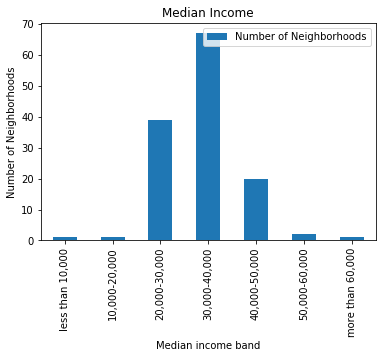

In [15]:
# Create bar chart
binned.plot.bar(x='binned', y='Number of Neighborhoods')

plt.title('Median Income')
plt.ylabel('Number of Neighborhoods')
plt.xlabel('Median income band')
plt.xticks(rotation=90)

plt.show()

##### High earning neighborhoods defined as median income above mean

In [16]:
top_income = hobart[hobart['median_income'] > hobart['median_income'].mean()].reset_index(drop = True)
print('There are ' + str(top_income[['Neighborhood', 'median_income']].shape[0]) + ' neighborhoods above ' + str(hobart['median_income'].mean()) + ' mean income')
top_income[['Neighborhood', 'median_income']].head()

There are 66 neighborhoods above 33614.62595419848 mean income


,Neighborhood,median_income
0,Acton Park,43472.0
1,Allens Rivulet,37544.0
2,Apollo Bay,39416.0
3,Barretta,34788.0
4,Battery Point,47164.0


#### Analysis and visualisation by population

In [17]:
pop = hobart[['Neighborhood', 'LGA', 'population', 'area_sq_km','pop_density']].sort_values('pop_density', ascending=False).reset_index(drop=True)
pop.head()

,Neighborhood,LGA,population,area_sq_km,pop_density
0,Glebe,Hobart,554,0.165,3357.575758
1,Battery Point,Hobart,1997,0.677,2949.778434
2,North Hobart,Hobart,2494,1.018,2449.901768
3,Mount Stuart,Hobart,2399,1.034,2320.116054
4,West Moonah,Glenorchy,4012,1.809,2217.799889


###### Descriptive staistics

In [18]:
#descriptive staistics
pop.describe()

,population,area_sq_km,pop_density
count,131.000000,131.000000,131.000000
mean,1671.038168,17.369084,450.771286
std,2289.692859,29.542570,677.714237
min,0.000000,0.165000,0.000000
25%,225.500000,2.345000,17.928629
50%,657.000000,7.332000,87.174620
75%,2324.500000,17.033000,629.528486
max,11927.000000,208.351000,3357.575758


In [19]:
print ('Total population for the region is ' + str(pop['population'].sum()))
print ('Median population density for the region is ' + str(pop['pop_density'].median()))
print ('Mean population density for the region is ' + str(pop['pop_density'].mean()))
print ('Highest Population density for the region is ' + str(pop['pop_density'].max()))
print ('Lowest Population density for the region is ' + str(pop['pop_density'].min()))

Total population for the region is 218906
Median population density for the region is 87.17462039045553
Mean population density for the region is 450.77128595762605
Highest Population density for the region is 3357.5757575757575
Lowest Population density for the region is 0.0


In [20]:
# Compare LGAs population densities
LGA_pop= hobart[['LGA', 'pop_density']].groupby('LGA').median()
LGA_pop.sort_values('pop_density', ascending=False, inplace=True)
LGA_pop

,pop_density
LGA,
Hobart,1034.776903
Glenorchy,700.170029
Clarence,217.493374
Brighton,142.161297
Kingborough,30.586393
Sorell,15.495227


###### Population density Bar chart

In [21]:
#creating bins
pop = hobart[['Neighborhood','pop_density']]
bins = [-1,100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
labels = ['less than 100', '101 - 500','501 - 1000','1001- 1500','1501- 2000','2001- 2500','2501- 3000', '3001-3500', 'more than 3500']
pop['binned'] = pd.cut(pop['pop_density'], bins=bins, labels=labels)

#group number of neighborhoods per bin
binned = pop.groupby(['binned'])[['Neighborhood']].count()
binned.rename(columns = {'Neighborhood':'Number of Neighborhoods'}, inplace = True)
binned.reset_index(inplace = True)
binned

C:\Users\akedi\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,binned,Number of Neighborhoods
0,less than 100,68
1,101 - 500,23
2,501 - 1000,14
3,1001- 1500,14
4,1501- 2000,7
5,2001- 2500,3
6,2501- 3000,1
7,3001-3500,1
8,more than 3500,0


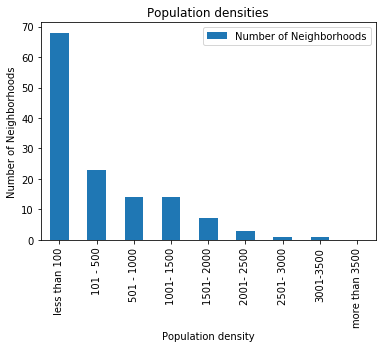

In [22]:
# Create bar chart
binned.plot.bar(x='binned', y='Number of Neighborhoods')

plt.title('Population densities')
plt.ylabel('Number of Neighborhoods')
plt.xlabel('Population density')
plt.xticks(rotation=90)

plt.show()

##### Densely populated neighborhoods defined as population desity above mean

In [23]:
top_pop = hobart[hobart['pop_density'] > hobart['pop_density'].mean()].reset_index(drop = True)
print('There are ' + str(top_pop[['Neighborhood', 'pop_density']].shape[0]) + ' neighborhoods above ' + str(hobart['pop_density'].mean()) + ' mean population density')
top_pop[['Neighborhood', 'median_income']].head()

There are 41 neighborhoods above 450.77128595762605 mean population density


,Neighborhood,median_income
0,Austins Ferry,33436.0
1,Battery Point,47164.0
2,Bellerive,35308.0
3,Berriedale,29172.0
4,Blackmans Bay,36816.0


#### Selecting candidate neighborhoods

That is neighbourhoods with median income and population density above mean

In [24]:
#neigborhoods with median income above mean neighborhood median income
neighborhoods = top_income

# then neigborhoods with population density above mean
neighborhoods = neighborhoods[neighborhoods['pop_density'] > neighborhoods['pop_density'].mean()].reset_index(drop = True)

print('There are ' + str(neighborhoods.shape[0]) + ' neighborhoods with population density above ' + 
      str(hobart['pop_density'].mean()) + ' and median income above ' + str(hobart['median_income'].mean()))

There are 20 neighborhoods with population density above 450.77128595762605 and median income above 33614.62595419848


In [25]:
#feature selection
features = ['Neighborhood', 'postcode', 'LGA', 'latitude', 'longitude', 'median_income', 'pop_density']
neighborhoods = neighborhoods[features]
print(neighborhoods.shape)
neighborhoods.head()

(20, 7)


,Neighborhood,postcode,LGA,latitude,longitude,median_income,pop_density
0,Battery Point,7004,Hobart,-42.89277,147.33324,47164.0,2949.778434
1,Bellerive,7018,Clarence,-42.87482,147.36763,35308.0,1593.142453
2,Blackmans Bay,7052,Kingborough,-42.99887,147.31895,36816.0,1151.490733
3,Glebe,7000,Hobart,-42.87403,147.32635,43732.0,3357.575758
4,Howrah,7018,Clarence,-42.88869,147.40568,37440.0,1323.887873


In [26]:
# map of to high earning and populated neighborhoods

map_top = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(neighborhoods['latitude'], neighborhoods['longitude'], neighborhoods['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_top)  
    
map_top

### 4.2 Venues data

In [27]:
# Foursquare Credentials and Version

CLIENT_ID = '5CC1O4CUJ4TKBRMUL53QVWZYEBYWSI1CDUUNQ4CG1M0NDSUW' # your Foursquare ID
CLIENT_SECRET = 'K5FTYYNGHLSF0RWOUHMPYQN2O0ZO0124ECQVQE5D520GYIGP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5CC1O4CUJ4TKBRMUL53QVWZYEBYWSI1CDUUNQ4CG1M0NDSUW
CLIENT_SECRET:K5FTYYNGHLSF0RWOUHMPYQN2O0ZO0124ECQVQE5D520GYIGP


In [28]:
# first neighborhood
neighborhoods.loc[0, 'Neighborhood']

'Battery Point'

In [29]:
# first neighborhood coordinates
neighborhood_latitude = neighborhoods.loc[0, 'latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[0, 'longitude'] # neighborhood longitude value

neighborhood_name = neighborhoods.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Battery Point are -42.89277, 147.33324.


#### Venues that are in first neighborhood within radius 500m

In [30]:
# first neighborhood venues
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=5CC1O4CUJ4TKBRMUL53QVWZYEBYWSI1CDUUNQ4CG1M0NDSUW&client_secret=K5FTYYNGHLSF0RWOUHMPYQN2O0ZO0124ECQVQE5D520GYIGP&v=20180605&ll=-42.89277,147.33324&radius=1000&limit=100'

In [31]:
results = requests.get(url).json()
#results

In [32]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [33]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

C:\Users\akedi\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Pollen Tea Room,Tea Room,-42.889620,147.334024
1,Preachers,Bar,-42.888629,147.331402
2,Ristorante Da Angelo,Italian Restaurant,-42.889584,147.334214
3,Arthur Circus,Playground,-42.888972,147.335070
4,Society Salamanca,Bar,-42.887530,147.331393


In [34]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

92 venues were returned by Foursquare.


In [35]:
# repeating process for all neighborhoods in dataframe
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        except:
            print('error')
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [36]:

venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['latitude'],
                                   longitudes=neighborhoods['longitude']
                                  )



Battery Point
Bellerive
Blackmans Bay
Glebe
Howrah
Kingston Beach
Lenah Valley
Lindisfarne
Montagu Bay
Mount Stuart
North Hobart
Oakdowns
Rose Bay
Rosny
Sandy Bay
South Hobart
Taroona
Tolmans Hill
Tranmere
West Hobart


In [37]:
print(venues.shape)
venues.head(10)

(732, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Battery Point,-42.89277,147.33324,Pollen Tea Room,-42.889620,147.334024,Tea Room
1,Battery Point,-42.89277,147.33324,Preachers,-42.888629,147.331402,Bar
2,Battery Point,-42.89277,147.33324,Ristorante Da Angelo,-42.889584,147.334214,Italian Restaurant
3,Battery Point,-42.89277,147.33324,Society Salamanca,-42.887530,147.331393,Bar
4,Battery Point,-42.89277,147.33324,Sash Coffee,-42.894476,147.326224,Coffee Shop
5,Battery Point,-42.89277,147.33324,Salamanca Market,-42.886577,147.331896,Market
6,Battery Point,-42.89277,147.33324,Arthur Circus,-42.888972,147.335070,Playground
7,Battery Point,-42.89277,147.33324,Annapurna,-42.886804,147.334979,Indian Restaurant
8,Battery Point,-42.89277,147.33324,Solo Pasta & Pizza,-42.894914,147.325880,Italian Restaurant
9,Battery Point,-42.89277,147.33324,Tricycle Cafe,-42.886739,147.333758,Café


### Clustering neighborhoods

In [38]:
venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Point,82,82,82,82,82,82
Bellerive,31,31,31,31,31,31
Blackmans Bay,8,8,8,8,8,8
Glebe,94,94,94,94,94,94
Howrah,18,18,18,18,18,18
Kingston Beach,19,19,19,19,19,19
Lenah Valley,4,4,4,4,4,4
Lindisfarne,13,13,13,13,13,13
Montagu Bay,34,34,34,34,34,34


In [39]:
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))

There are 95 uniques categories.


In [40]:
# one hot encoding
venues_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
venues_onehot['Neighborhood'] = venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]

venues_onehot.head()

,Neighborhood,Asian Restaurant,Assisted Living,Athletics & Sports,Australian Restaurant,Bagel Shop,Bakery,Bar,Bay,Beach,Bistro,Bookstore,Breakfast Spot,Brewery,Burger Joint,Bus Station,Business Service,Café,Chinese Restaurant,Cocktail Bar,Coffee Shop,Construction & Landscaping,Convenience Store,Cricket Ground,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Distillery,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Garden,Gas Station,Gastropub,General Entertainment,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Historic Site,History Museum,Home Service,Hotel,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Liquor Store,Market,Mexican Restaurant,Movie Theater,Museum,Music Store,Noodle House,Park,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Portuguese Restaurant,Pub,Rental Service,Restaurant,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shop & Service,Shopping Mall,Snack Place,Spa,Stadium,Supermarket,Sushi Restaurant,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Thrift / Vintage Store,Trail,Wine Bar,Yoga Studio
0,Battery Point,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,Battery Point,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Battery Point,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Battery Point,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Battery Point,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [41]:
venues_onehot.shape

(732, 96)

In [42]:
venues_grouped = venues_onehot.groupby('Neighborhood').mean().reset_index()
venues_grouped.head()

,Neighborhood,Asian Restaurant,Assisted Living,Athletics & Sports,Australian Restaurant,Bagel Shop,Bakery,Bar,Bay,Beach,Bistro,Bookstore,Breakfast Spot,Brewery,Burger Joint,Bus Station,Business Service,Café,Chinese Restaurant,Cocktail Bar,Coffee Shop,Construction & Landscaping,Convenience Store,Cricket Ground,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Distillery,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Garden,Gas Station,Gastropub,General Entertainment,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Historic Site,History Museum,Home Service,Hotel,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Liquor Store,Market,Mexican Restaurant,Movie Theater,Museum,Music Store,Noodle House,Park,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Portuguese Restaurant,Pub,Rental Service,Restaurant,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shop & Service,Shopping Mall,Snack Place,Spa,Stadium,Supermarket,Sushi Restaurant,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Thrift / Vintage Store,Trail,Wine Bar,Yoga Studio
0,Battery Point,0.012195,0.0,0.000000,0.012195,0.012195,0.036585,0.036585,0.0,0.000000,0.012195,0.012195,0.024390,0.0,0.024390,0.000000,0.0,0.097561,0.0,0.024390,0.085366,0.0,0.0,0.000000,0.0,0.000000,0.012195,0.000000,0.000000,0.012195,0.012195,0.000000,0.012195,0.000,0.012195,0.012195,0.0,0.012195,0.012195,0.0,0.036585,0.012195,0.0,0.0,0.000000,0.024390,0.012195,0.012195,0.000000,0.0,0.0,0.000000,0.073171,0.036585,0.000000,0.000000,0.036585,0.012195,0.012195,0.0,0.0,0.000000,0.012195,0.000000,0.000000,0.012195,0.000000,0.0,0.048780,0.0,0.000000,0.012195,0.012195,0.012195,0.000000,0.036585,0.000000,0.024390,0.000000,0.000000,0.012195,0.000000,0.000000,0.0,0.000000,0.000000,0.012195,0.000000,0.012195,0.000000,0.024390,0.0,0.012195,0.000000,0.000000,0.0
1,Bellerive,0.032258,0.0,0.000000,0.032258,0.000000,0.032258,0.000000,0.0,0.032258,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.064516,0.0,0.000000,0.000000,0.0,0.0,0.032258,0.0,0.032258,0.000000,0.064516,0.032258,0.000000,0.000000,0.096774,0.000000,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.032258,0.032258,0.000000,0.000000,0.032258,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.032258,0.000000,0.032258,0.0,0.0,0.000000,0.000000,0.000000,0.032258,0.000000,0.032258,0.0,0.000000,0.0,0.000000,0.032258,0.000000,0.000000,0.032258,0.032258,0.032258,0.000000,0.032258,0.032258,0.064516,0.000000,0.000000,0.0,0.032258,0.032258,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
2,Blackmans Bay,0.000000,0.0,0.000000,0.125000,0.000000,0.000000,0.125000,0.0,0.125000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.250000,0.0,0.000000,0.125000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.125000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
3,Glebe,0.010638,0.0,0.000000,0.042553,0.010638,0.042553,0.031915,0.0,0.000000,0.010638,0.021277,0.010638,0.0,0.021277,0.000000,0.0,0.117021,0.0,0.010638,0.053191,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.021277,0.010638,0.010638,0.000000,0.000000,0.000,0.010638,0.000000,0.0,0.010638,0.010638,0.0,0.021277,0.010638,0.0,0.0,0.021277,0.021277,0.000000,0.010638,0.000000,0.0,0.0,0.000000,0.042553,0.042553,0.010638,0.010638,0.031915,0.021

venues_grouped = use.join(venues_grouped.set_index('Neighborhood'), on='Neighborhood')

In [43]:
venues_grouped.shape

(20, 96)

#### Let's print each neighborhood along with the top 5 most common venues

In [44]:
num_top_venues = 5

for hood in venues_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = venues_grouped[venues_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Point----
         venue  freq
0         Café  0.10
1  Coffee Shop  0.09
2        Hotel  0.07
3         Park  0.05
4          Pub  0.04


----Bellerive----
                  venue  freq
0  Fast Food Restaurant  0.10
1      Department Store  0.06
2    Seafood Restaurant  0.06
3                  Café  0.06
4      Asian Restaurant  0.03


----Blackmans Bay----
                   venue  freq
0                   Café  0.25
1  Australian Restaurant  0.12
2      Fish & Chips Shop  0.12
3                    Bar  0.12
4                  Beach  0.12


----Glebe----
                   venue  freq
0                   Café  0.12
1                    Pub  0.05
2            Coffee Shop  0.05
3      Indian Restaurant  0.04
4  Australian Restaurant  0.04


----Howrah----
           venue  freq
0  Grocery Store  0.11
1   Home Service  0.11
2   Liquor Store  0.11
3      Bookstore  0.06
4       Pharmacy  0.06


----Kingston Beach----
                  venue  freq
0         Grocery Store  0.16


#### Let's put that into a pandas dataframe

In [45]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [46]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = venues_grouped['Neighborhood']

for ind in np.arange(venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Point,Café,Coffee Shop,Hotel,Park,Italian Restaurant,Gastropub,Pub,Indian Restaurant,Bakery,Bar
1,Bellerive,Fast Food Restaurant,Café,Seafood Restaurant,Department Store,Grocery Store,Pizza Place,Music Store,Movie Theater,Juice Bar,Italian Restaurant
2,Blackmans Bay,Café,Grocery Store,Australian Restaurant,Bar,Beach,Coffee Shop,Fish & Chips Shop,Yoga Studio,French Restaurant,Dessert Shop
3,Glebe,Café,Pub,Coffee Shop,Bakery,Australian Restaurant,Indian Restaurant,Hotel,Bar,Italian Restaurant,Park
4,Howrah,Home Service,Liquor Store,Grocery Store,Pharmacy,Bookstore,Gastropub,Field,Bus Station,Sandwich Place,Shopping Mall
5,Kingston Beach,Grocery Store,Pizza Place,Fast Food Restaurant,Coffee Shop,Beach,Café,Fish & Chips Shop,Indian Restaurant,Shopping Mall,Seafood Restaurant
6,Lenah Valley,Bakery,Pizza Place,Café,French Restaurant,Deli / Bodega,Department Store,Dessert Shop,Distillery,Farmers Market,Fast Food Restaurant
7,Lindisfarne,Harbor / Marina,Park,Supermarket,Gas Station,Fast Food Restaurant,Pub,Breakfast Spot,Bay,Grocery Store,Trail
8,Montagu Bay,Pub,Bakery,Café,Department Store,Fast Food Restaurant,Grocery Store,Juice Bar,Pizza Place,Pet Store,Park
9,Mount Stuart,Café,Bakery,Coffee Shop,Hotel,Japanese Restaurant,Grocery Store,Liquor Store,Pizza Place,Dessert Shop,Indian Restaurant


### KMeans Clustering

In [47]:

from sklearn.cluster import KMeans

# function returns WSS score for k values from 1 to kmax
def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  return sse

In [48]:
hobart_grouped_clustering = venues_grouped.drop('Neighborhood', 1)

In [50]:
calculate_WSS(hobart_grouped_clustering, 10)

KeyError: (0, 0)

In [539]:
# set number of clusters
kclusters = 5

hobart_grouped_clustering = venues_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hobart_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:] 

array([0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 4, 3, 0])

In [540]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)

hobart_merged = neighborhoods

#  to add latitude/longitude for each neighborhood
hobart_merged = hobart_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
hobart_merged.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
hobart_merged.head() # check the last columns!

,Neighborhood,postcode,LGA,latitude,longitude,median_income,pop_density,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Point,7004,Hobart,-42.89277,147.33324,47164.0,2949.778434,0,Café,Coffee Shop,Hotel,Park,Italian Restaurant,Indian Restaurant,Bakery,Bar,Pub,Gastropub
1,Bellerive,7018,Clarence,-42.87482,147.36763,35308.0,1593.142453,0,Café,Coffee Shop,Hotel,Park,Italian Restaurant,Indian Restaurant,Bakery,Bar,Pub,Gastropub
2,Blackmans Bay,7052,Kingborough,-42.99887,147.31895,36816.0,1151.490733,0,Café,Grocery Store,Australian Restaurant,Bar,Coffee Shop,Beach,Fish & Chips Shop,Yoga Studio,Food Truck,Dessert Shop
3,Glebe,7000,Hobart,-42.87403,147.32635,43732.0,3357.575758,0,Café,Park,Pub,Coffee Shop,Indian Restaurant,Hotel,Italian Restaurant,Australian Restaurant,Bakery,Bar
4,Howrah,7018,Clarence,-42.88869,147.40568,37440.0,1323.887873,0,Grocery Store,Liquor Store,Home Service,Athletics & Sports,Shopping Mall,Gym,Pharmacy,Field,Bus Station,Gastropub


In [542]:

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hobart_merged['latitude'], hobart_merged['longitude'], hobart_merged['Neighborhood'], hobart_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Cluster 1

In [543]:
hobart_merged.loc[hobart_merged['Cluster_Labels'] == 0]

,Neighborhood,postcode,LGA,latitude,longitude,median_income,pop_density,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Point,7004,Hobart,-42.89277,147.33324,47164.0,2949.778434,0,Café,Coffee Shop,Hotel,Park,Italian Restaurant,Indian Restaurant,Bakery,Bar,Pub,Gastropub
1,Bellerive,7018,Clarence,-42.87482,147.36763,35308.0,1593.142453,0,Café,Coffee Shop,Hotel,Park,Italian Restaurant,Indian Restaurant,Bakery,Bar,Pub,Gastropub
2,Blackmans Bay,7052,Kingborough,-42.99887,147.31895,36816.0,1151.490733,0,Café,Grocery Store,Australian Restaurant,Bar,Coffee Shop,Beach,Fish & Chips Shop,Yoga Studio,Food Truck,Dessert Shop
3,Glebe,7000,Hobart,-42.87403,147.32635,43732.0,3357.575758,0,Café,Park,Pub,Coffee Shop,Indian Restaurant,Hotel,Italian Restaurant,Australian Restaurant,Bakery,Bar
4,Howrah,7018,Clarence,-42.88869,147.40568,37440.0,1323.887873,0,Grocery Store,Liquor Store,Home Service,Athletics & Sports,Shopping Mall,Gym,Pharmacy,Field,Bus Station,Gastropub
5,Kingston Beach,7050,Kingborough,-42.98101,147.32286,34424.0,1340.067340,0,Grocery Store,Fast Food Restaurant,Pizza Place,Supermarket,Fish & Chips Shop,Café,Shopping Mall,Beach,Coffee Shop,Bar
7,Lindisfarne,7015,Clarence,-42.84772,147.35295,35568.0,889.704824,0,Park,Harbor / Marina,Pub,Trail,Grocery Store,Gas Station,Bakery,Supermarket,Bay,Fast Food Restaurant
8,Montagu Bay,7018,Clarence,-42.86351,147.35581,33644.0,1466.517857,0,Harbor / Marina,Café,Department Store,Grocery Store,Fast Food Restaurant,Bakery,Pub,Coffee Shop,Dessert Shop,Juice Bar
9,Mount Stuart,7000,Hobart,-42.87312,147.30230,44616.0,2320.116054,0,Café,Bakery,Japanese Restaurant,Hotel,Pizza Place,Asian Restaurant,Dessert Shop,Italian Restaurant,Indian Restaurant,Park
10,North Hobart,7000,Hobart,-42.87232,147.31458,37544.0,2449.901768,0,Café,Coffee Shop,Pub,Hotel,Australian Restaurant,Bakery,Park,Grocery Store,Indian Restaurant,Dessert Shop


In [546]:
hobart_merged.loc[hobart_merged['Cluster_Labels'] == 0].describe(include=['object'])

,Neighborhood,LGA,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,16,16,16,16,16,16,16,16,16,16,16,16
unique,16,3,8,9,10,11,15,13,13,15,13,11
top,Bellerive,Hobart,Café,Coffee Shop,Pub,Park,Italian Restaurant,Indian Restaurant,Bakery,Bar,Indian Restaurant,Gastropub
freq,1,7,8,5,5,3,2,2,3,2,2,3


In [551]:
cafe_cluster = hobart_merged.loc[hobart_merged['Cluster_Labels'] == 0]

#### Cluster 2

In [547]:
hobart_merged.loc[hobart_merged['Cluster_Labels'] == 1]

,Neighborhood,postcode,LGA,latitude,longitude,median_income,pop_density,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Oakdowns,7019,Clarence,-42.90034,147.45758,42120.0,1908.972692,1,Chinese Restaurant,Café,Yoga Studio,Dance Studio,Department Store,Dessert Shop,Distillery,Farmers Market,Fast Food Restaurant,Field


#### Cluster 3

In [548]:
hobart_merged.loc[hobart_merged['Cluster_Labels'] == 2]

,Neighborhood,postcode,LGA,latitude,longitude,median_income,pop_density,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Lenah Valley,7008,Hobart,-42.86584,147.27797,40144.0,708.830549,2,Bakery,Asian Restaurant,Café,Food Truck,Department Store,Dessert Shop,Distillery,Farmers Market,Fast Food Restaurant,Field


#### Cluster 4

In [549]:
hobart_merged.loc[hobart_merged['Cluster_Labels'] == 3]

,Neighborhood,postcode,LGA,latitude,longitude,median_income,pop_density,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Tranmere,7018,Clarence,-42.92278,147.41639,45500.0,597.471022,3,Construction & Landscaping,Home Service,Yoga Studio,Food Truck,Department Store,Dessert Shop,Distillery,Farmers Market,Fast Food Restaurant,Field


#### Cluster 5

In [550]:
hobart_merged.loc[hobart_merged['Cluster_Labels'] == 4]

,Neighborhood,postcode,LGA,latitude,longitude,median_income,pop_density,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Tolmans Hill,7007,Hobart,-42.91461,147.3084,56992.0,543.54067,4,Dance Studio,Grocery Store,Theater,Bookstore,Food Truck,Deli / Bodega,Department Store,Dessert Shop,Distillery,Farmers Market


---------------------------------------------------------------------------------------------------------------------------

## 5. Results <a name="results"></a>

The Median income for the region is AUD33,644 and Mean income for the region is AUD33,614.62.The highest neighborhood median income for the region is AUD69,836 while the lowest was 0.0. There were 66 neighborhoods above AUD33,614.62 mean income.

Total population for the region is 218906 with median population density of 87/sqm and mean population density of is 450.77/sqm. The highest Population density for the region is 3,358 and the lowest is 0. There are 41 neighborhoods above 451 mean population density

There were 20 neighborhoods with population density above 450.77/sqm and median income above AUD33,614.62. These were chosen for further analysis and clustering.

Our model shows that cluster 2 is cafe and coffee shop region with a good variety of venues. Unsuprisingly these neighborhoods are close to the city centre. Below are recommended neighborhoods from this cluster where cafe/coffee shop is not in the top 2. These neighborhoods have high population density, above median incomes and similar in terms of venues. 

In [557]:
# recommended neighborhoods to open cafes
choice = cafe_cluster[cafe_cluster['1st Most Common Venue'] != 'Café']
choice = choice[choice['2nd Most Common Venue'] != 'Coffee Shop']
choice['Neighborhood']

4             Howrah
5     Kingston Beach
7        Lindisfarne
8        Montagu Bay
12          Rose Bay
13             Rosny
14         Sandy Bay
16           Taroona
Name: Neighborhood, dtype: object

-----------------------------------------------------------------------------------------------------------------------

## 6. Discussion and Conclusion<a name="discussion"></a>

Using neighborhood income, population density and venues data we recommended some neighborhoods to open a cafe/cofee shop. We hope this helps investors shortlist locations better. The model can be improved further for example by using foot traffic in the analysis and using businesses/workplaces that do not appear in the Foursquare data.

----------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 7. References <a name="references"></a>

1.	AustralianTownsList.com - https://www.australiantownslist.com/
3.	Australian Bureau of Statistics -https://www.abs.gov.au/AUSSTATS/abs@.nsf/DetailsPage/6524.0.55.0022011-12%20to%202016-17?OpenDocument
